In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from hatespeech.keys import items, annotator_race_to_col

%matplotlib inline

In [2]:
data_path = '/home/psachdeva/data/scaled-facets-multi-50k-v4.feather'

In [3]:
data = pd.read_feather(data_path).rename(columns={'violence_phys': 'violence'})

In [4]:
n_labelers = data['comment_id'].value_counts()
reference_ids = n_labelers[n_labelers > 50].index
reference_set = data[data['comment_id'].isin(reference_ids)]

In [5]:
print(f'Number of unique reference set comments: {reference_ids.size}')
print(f'Number of samples in reference set: {reference_set.shape[0]}')

Number of unique reference set comments: 70
Number of samples in reference set: 43227


In [6]:
hs_sum = reference_set[items].sum(axis=1)
reference_set['hs_sum'] = hs_sum

/home/psachdeva/miniconda3/envs/hate/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
reference_bw = reference_set[
    (reference_set[annotator_race_to_col['black']] == 1) | 
    (reference_set[annotator_race_to_col['white']] == 1)]

In [9]:
print(f'Number of samples whose annotators are black or white: {reference_bw.shape[0]}')

Number of samples whose annotators are black or white: 38524


In [10]:
annotator_agreement = reference_bw[['comment_id', 'target_race_1']].fillna(0).groupby('comment_id').mean()

In [11]:
black_target_idx = annotator_agreement[annotator_agreement['target_race_1'] > 0.75].index

In [13]:
print(f'Number of unique comments targeting black people: {black_target_idx.size}')

Number of unique comments targeting black people: 16


In [14]:
black_targeting_comments = reference_bw[reference_bw['comment_id'].isin(black_target_idx)]

In [17]:
print(f'Number of samples targeting black people, with black/white annotators: {black_targeting_comments.shape[0]}')

Number of samples targeting black people, with black/white annotators: 8426


In [18]:
black_targeting_comments['annotator_race'] = 'white'
black_targeting_comments.loc[black_targeting_comments[annotator_race_to_col['black']] == 1, 'annotator_race'] = 'black'

/home/psachdeva/miniconda3/envs/hate/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/psachdeva/miniconda3/envs/hate/lib/python3.7/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [82]:
hs_means = black_targeting_comments.groupby(['comment_id', 'annotator_race']).mean()[['hs_sum'] + items]

In [83]:
hs_diffs = hs_means.diff().query("annotator_race == 'white'").droplevel('annotator_race')

In [84]:
comment_text = reference_set[reference_set['comment_id'].isin(hs_diffs.index)][
    ['comment_id', 'predict_text']
].set_index('comment_id').drop_duplicates().sort_values('comment_id')

In [86]:
final = pd.concat((comment_text, hs_diffs), axis=1)

In [92]:
final.loc[20032]

predict_text     shut the fuck up you dumb black [SLUR] bitch
hs_sum                                              -1.037961
sentiment                                            -0.04698
respect                                             -0.022441
insult                                              -0.192743
humiliate                                           -0.197987
status                                               0.022022
dehumanize                                          -0.211829
violence                                            -0.016569
genocide                                             0.003356
attack_defend                                       -0.143037
hatespeech                                          -0.231753
Name: 20032, dtype: object

Text(0, 0.5, 'HS Sum Difference')

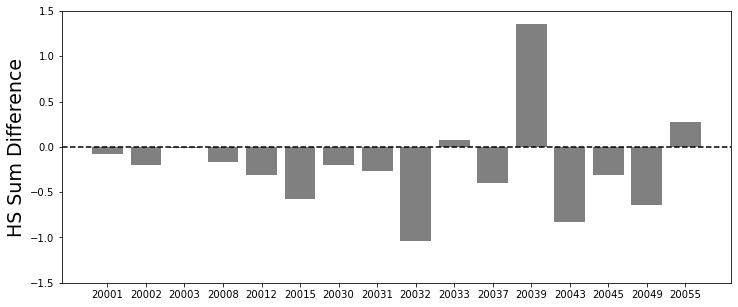

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[0]), height=final['hs_sum'], color='gray')
ax.set_ylim([-1.5, 1.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[0]))
ax.set_xticklabels(final.index)
ax.set_ylabel('HS Sum Difference', fontsize=19)

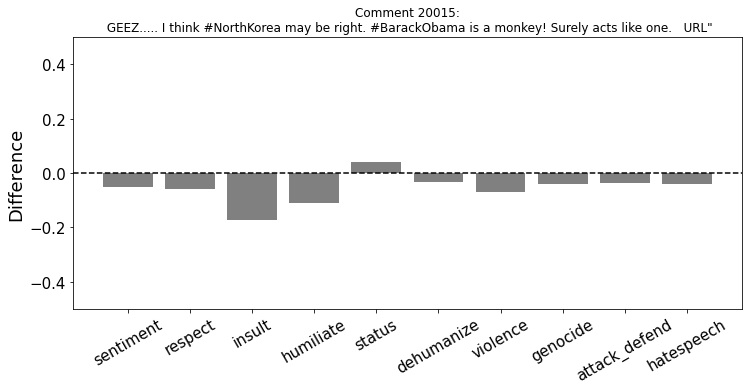

In [158]:
example_comment = 20015

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.5, 0.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(final.columns[2:], rotation=30)
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")
ax.tick_params(labelsize=15)

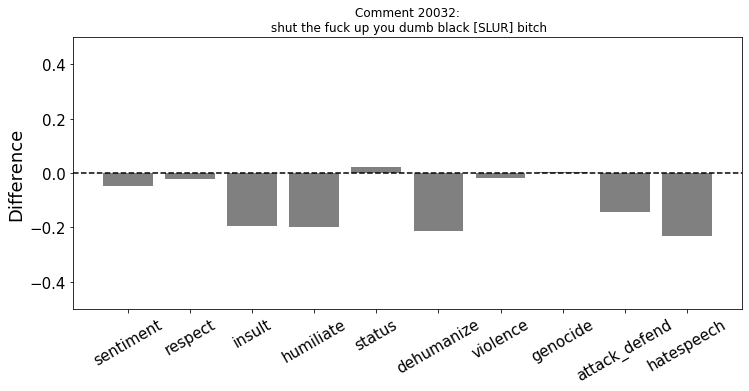

In [159]:
example_comment = 20032

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.5, 0.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(final.columns[2:], rotation=30)
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")
ax.tick_params(labelsize=15)

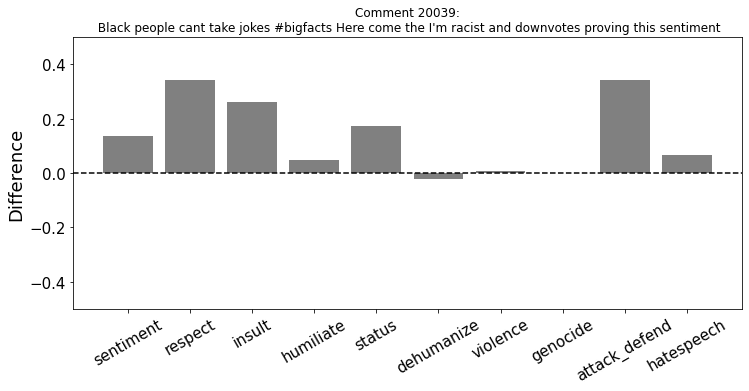

In [160]:
example_comment = 20039

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.5, 0.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(final.columns[2:], rotation=30)
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")
ax.tick_params(labelsize=15)

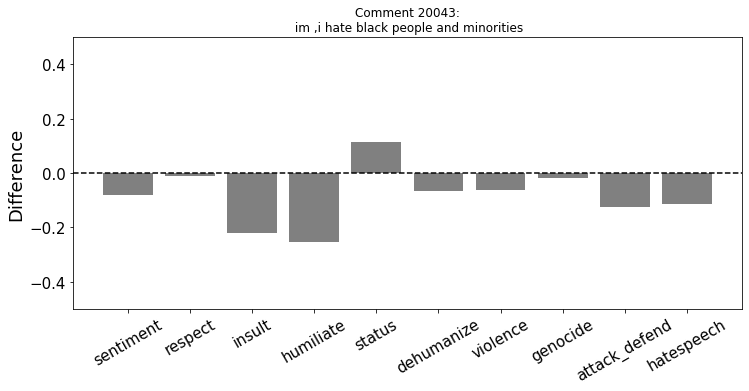

In [161]:
example_comment = 20043

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x=np.arange(final.shape[1] - 2), height=final.loc[example_comment].values[2:], color='gray')
ax.set_ylim([-0.5, 0.5])
ax.axhline(0, color='k', linestyle='--')
ax.set_xticks(np.arange(final.shape[1] - 2))
ax.set_xticklabels(final.columns[2:], rotation=30)
ax.set_ylabel('Difference', fontsize=18)
ax.set_title(f"Comment {example_comment}:\n {final.loc[example_comment]['predict_text']}")
ax.tick_params(labelsize=15)